# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params
theta = 0.1 

move_control = 0.9

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 0

infection_seed_size = 100

hospitalization_duration = 14.0

alpha = [0.1, 0.3, 0.2]



# sdh with pei movement

### plots sdh model by prevalence
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/sdh_params.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv 
### creats sirh_sdh
python -m epymorph run --ipm sdh --mm icecube --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv 

In [50]:
from epymorph.run import run
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.simulation import Simulation
from epymorph.world import Population 

import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import numpy as np
import os

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')
with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)


In [13]:
exit_code = run(
    ipm_name = 'sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/sdh_params.toml",
    out_path = None,
    chart = 'p0',
    profiling=False
)

Loading requirements:
[✓] IPM (sdh)
[✓] MM (icecube)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/sdh_params.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2505 geo nodes


ValueError: colors must be a one-dimensional sequence of nonnegative integers not exceeding 9223372036854775807.

In [ ]:
# Note: the 'library' dictionaries contain functions which load the named component,
# so you have to apply the function to get the _actual_ component.

# The 'pei' model family (IPM/MM/GEO) implement an SIRS model in 6 US states.
# (Remember: it is possible to mix-and-match the models!)
sim = Simulation(
    geo=geo_library['maricopa_cbg_2019'](),
    ipm_builder=ipm_library['sdh'](),
    mvm_builder=mm_library['centroids']()
)

out = sim.run(
    param={
        'theta': 0.1,
        'move_control': 0.9,
        'infection_duration': 4.0,
        'immunity_duration': 90.0,
        'infection_seed_loc': 2451,
        'infection_seed_size': 9708,
        'hospitalization_duration': 14.0,
        'alpha': [0.1, 0.3, 0.2],
        'phi': 40,
    },
    start_date=date(2015, 1, 1),
    duration_days=150,
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(29)
)


# Formatting the sdh.csv to be more readable
np.exp(g0 * (((g1 * scale_h1) + (g2 * scale_h2))) / (1 + np.exp(((g1 *scale_h1) + (g2 * scale_h2)))))

In [5]:
header_names = ['days', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']
df = pd.read_csv(dir + '/output_files/sdh.csv', header= None, skiprows = 1, names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']
df.groupby(['days']).sum().drop(labels= 'tracts', axis='columns').sort_index().to_csv(dir + '/output_files/sdh_sort.csv')


In [57]:
geo_df = pd.DataFrame({k: list(v) for k, v in data.items()})
#print(df[df.eq("040130715151").any(axis=1)])
geo_df['gamma'] = 0 
geo_df['gamma 0'] = 0

geo_df['beta'] = 0
geo_df['alpha 0'] = 0.1
geo_df["alpha 1"] = 0.8
geo_df["alpha 2"] = 0.2    

for i in range(len(geo_df)):
    # Alpha values used to control beta
    a0 = geo_df['alpha 0'][i]
    a1 = geo_df['alpha 1'][i]
    a2 = geo_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = geo_df["average_household_size"][i]
    x2 = geo_df["pop_density_km2"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = geo_df["median_income"][i]
    h2 = geo_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - geo_df["average_household_size"].mean()) / geo_df["average_household_size"].std()
    scale_x2 = (x2 - geo_df["pop_density_km2"].mean()) / geo_df["pop_density_km2"].std()
    scale_h1 = (h1 - geo_df["median_income"].mean()) / geo_df["median_income"].std()
    scale_h2 = (h2 - geo_df["tract_gini_index"].mean()) / geo_df["tract_gini_index"].std()
    
    # Calculate gamma based on Alpha values used to control gamma
    g0 = geo_df["gamma 0"][i]
    for x in np.arange(0.01, 0.03, 0.001):
        median_income = geo_df.sort_values(by= 'median_income')              
        gini_index = geo_df.sort_values(by= 'tract_gini_index')
        g0 = 0.00290022
        geo_df.loc[i, 'gamma 0'] = g0

    # Calculate the value of beta and gramma for each nodes
    beta = np.exp((a0 + (a1 * scale_x1) * (a2 * scale_x2)))
    gamma = g0 * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))

    # Saved the calculate value of beta and gamma in its respected node index
    geo_df.loc[i, ['beta', 'gamma']] = [beta, gamma]
geo_df.to_csv(dir + '/utility/geo.csv')

In [62]:
i = 0
geo_df['gamma 0'] = -1
geo_df['gamma 1'] = 0.01
geo_df["gamma 2"] = 0.01

g0 = geo_df["gamma 0"][i]
g1 = geo_df['gamma 1'][i]
g2 = geo_df['gamma 2'][i]

h1 = geo_df["total_income"][i]
h1_min = geo_df["total_income"].min()
h1_max = geo_df["total_income"].max()
print(h1, h1_min, h1_max)

h2 = geo_df["tract_gini_index"][i]
h2_min = geo_df["tract_gini_index"].min()
h2_max = geo_df["tract_gini_index"].max()
print(h2, h2_min, h2_max)

scale_h1 = (h1 - geo_df["median_income"].mean()) / geo_df["median_income"].std()
scale_h2 = (h2- h2_min / h2_max - h2_min)
print(scale_h1, scale_h2)
gamma = np.exp((g1 *scale_h1) + (g2 * scale_h2))/ (1 + np.exp(((g1 *scale_h1) + (g2 * scale_h2)))))
print(gamma)


SyntaxError: unmatched ')' (4187237037.py, line 23)

### plotting result

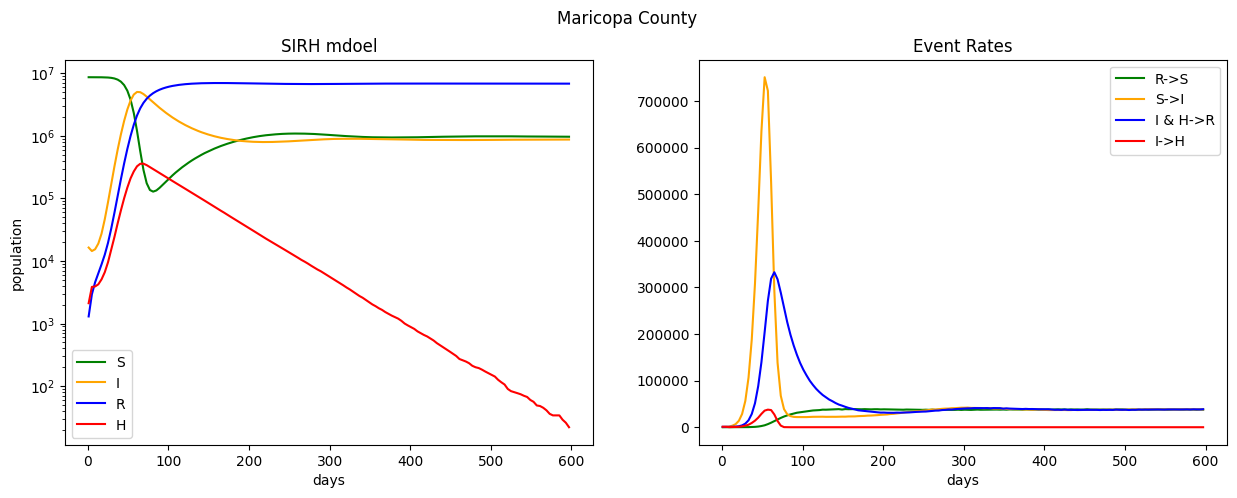

In [38]:
sdh = pd.read_csv(dir + '/output_files/sdh_sort.csv')
                 
# Get current axis
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = sdh[['days', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = sdh[['days', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['days'] // 2, sort=False).sum()
Events = Events.groupby(Events['days'] // 2, sort=False).sum()
# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            x='days',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[0],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            x='days',
            y=event_rate[i],
            color=color[i], 
            ax=axes[1],
            title = 'Event Rates')    
# show the plot
plt.show()



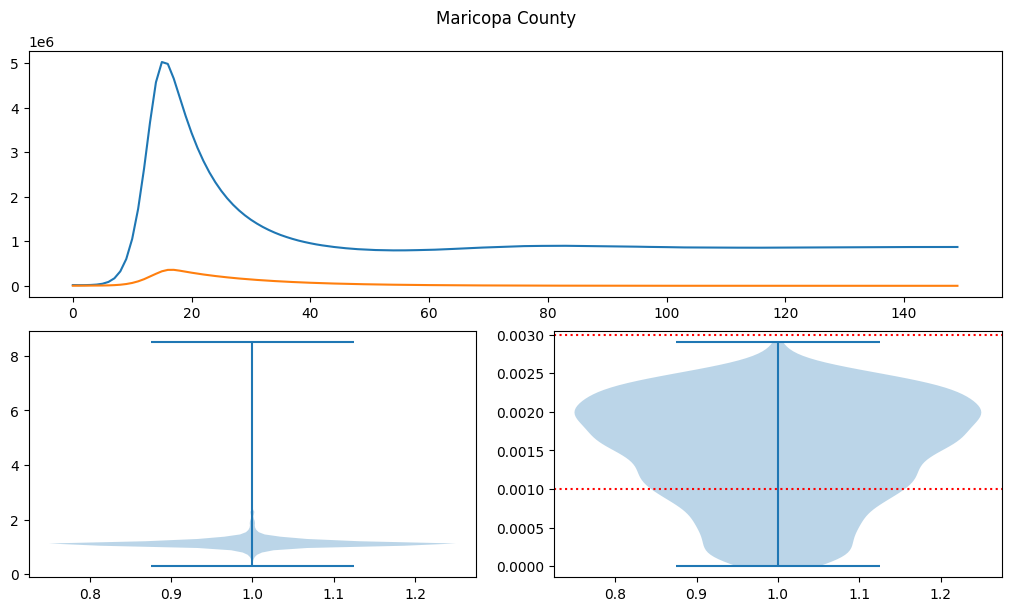

In [58]:
from matplotlib.pyplot import xlabel


fig = plt.figure(figsize=(10,6), layout="constrained")
spec = fig.add_gridspec(2, 2)
fig.suptitle('Maricopa County')

ax0 = fig.add_subplot(spec[0, :])
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])

ax0.plot(sirh_compartment['I'])
ax0.plot(sirh_compartment['H'])
ax10.violinplot(geo_df['beta'])
ax11.violinplot(geo_df['gamma'])
plt.axhline(y = 0.001, color = 'r', linestyle = 'dotted')
plt.axhline(y = 0.003, color = 'r', linestyle = 'dotted')

plt.show()
